# クラスタを階層木として構築する

## ボトムアップ方式
凝集型階層的クラスタリングには、標準アルゴリズムとして、単連結法と完全連結法の2つがある。  
単連結法では、クラスタのペアごとに最も類似度の高いメンバー同士の距離を計算し、それが最小となるような方法で2つのクラスタをマージする。  
完全連結法は単連結法に似ているが、クラスタのペアごとに最も類似度の高いメンバーを比較するのではなく、最も類似度の低いメンバーを比較し、マージに利用する。2つのクラスタ間の距離は、それぞれのクラスタから1点ずつ選んだすべての組み合わせの中で最も遠い距離（最大距離）で定義される。クラスタが1つだけ残った状態になるまで繰り返す。

In [1]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [2]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [3]:
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.

    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.

    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.

    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the number of

In [4]:
row_clusters = linkage(df.values, method='complete', metric='euclidean')
# もしくは
# row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


row label 1, row label 2：統合されたクラスタのインデックス（もしくは元のデータ点の行番号）  
distance：2つのクラスタ間の距離（ここでは **最大距離** ：完全連結法）  
no. of items in clust.	：新たに統合されたクラスタに含まれるデータ点の個数

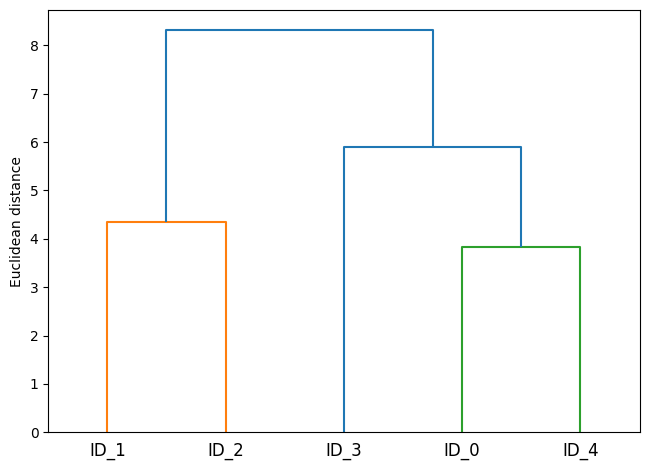

In [5]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('./figures/dendrogram.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

### ヒートマップ

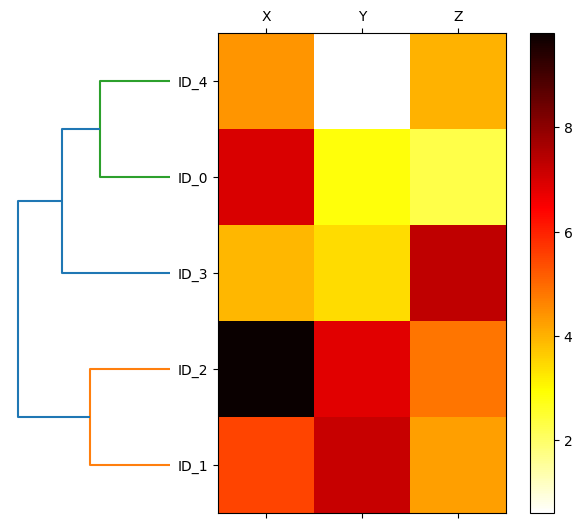

In [14]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)


# x軸
axm.set_xticks(np.arange(df_rowclust.shape[1]))
axm.set_xticklabels(df_rowclust.columns)

# y軸
axm.set_yticks(np.arange(df_rowclust.shape[0]))
axm.set_yticklabels(df_rowclust.index)


# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

### scikit-learn

In [17]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,
                             metric='euclidean',
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 0 0 2 1]
